In [ ]:
# Import các thư viện
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import scipy.sparse
import warnings
warnings.filterwarnings('ignore')

# Thêm các model khác
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB

In [56]:
# Đọc dữ liệu từ các file
df_train = pd.read_csv('data/train.csv')
df_valid = pd.read_csv('data/valid.csv')
df_test = pd.read_csv('data/test.csv')

Phân tích phân bố nhãn trong các tập dữ liệu:


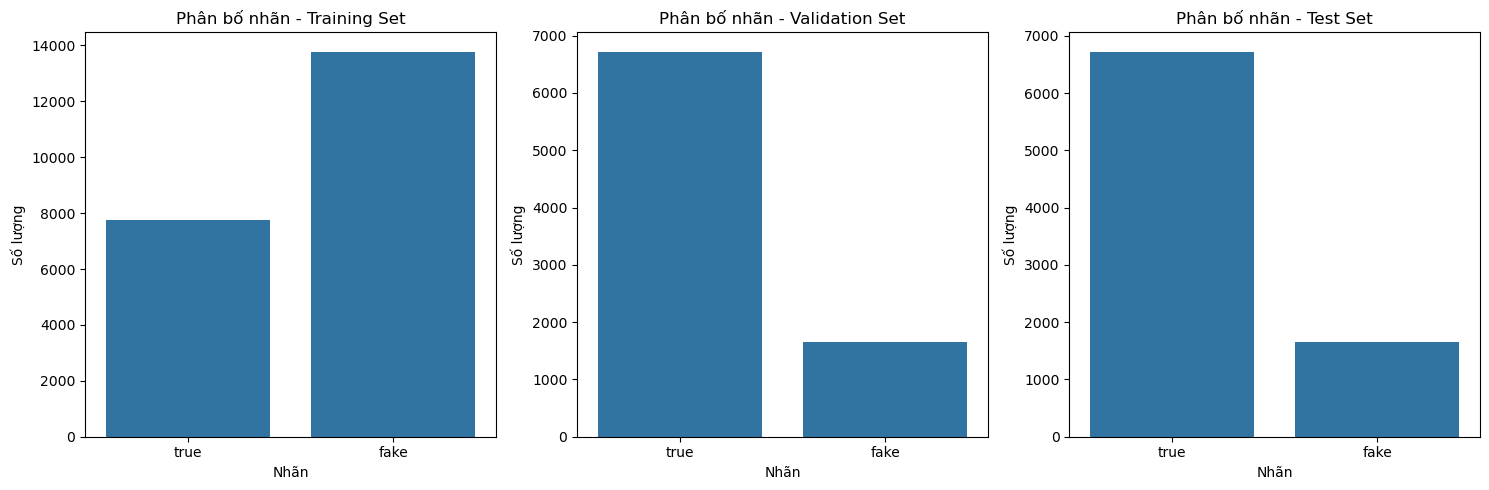


Tỷ lệ phân bố trong các tập:

Training set:
labels
fake    64.0
true    36.0
Name: proportion, dtype: float64

Validation set:
labels
true    80.2
fake    19.8
Name: proportion, dtype: float64

Test set:
labels
true    80.2
fake    19.8
Name: proportion, dtype: float64


In [57]:
# Phân tích phân bố nhãn trong các tập dữ liệu
print("Phân tích phân bố nhãn trong các tập dữ liệu:")
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Train set
sns.countplot(data=df_train, x='labels', ax=axes[0])
axes[0].set_title('Phân bố nhãn - Training Set')
axes[0].set_xlabel('Nhãn')
axes[0].set_ylabel('Số lượng')

# Valid set
sns.countplot(data=df_valid, x='labels', ax=axes[1])
axes[1].set_title('Phân bố nhãn - Validation Set')
axes[1].set_xlabel('Nhãn')
axes[1].set_ylabel('Số lượng')

# Test set
sns.countplot(data=df_test, x='labels', ax=axes[2])
axes[2].set_title('Phân bố nhãn - Test Set')
axes[2].set_xlabel('Nhãn')
axes[2].set_ylabel('Số lượng')

plt.tight_layout()
plt.show()

# In tỷ lệ phần trăm
print("\nTỷ lệ phân bố trong các tập:")
print("\nTraining set:")
print(df_train['labels'].value_counts(normalize=True).round(3) * 100)
print("\nValidation set:")
print(df_valid['labels'].value_counts(normalize=True).round(3) * 100)
print("\nTest set:")
print(df_test['labels'].value_counts(normalize=True).round(3) * 100)


Phân tích thống kê về độ dài văn bản:


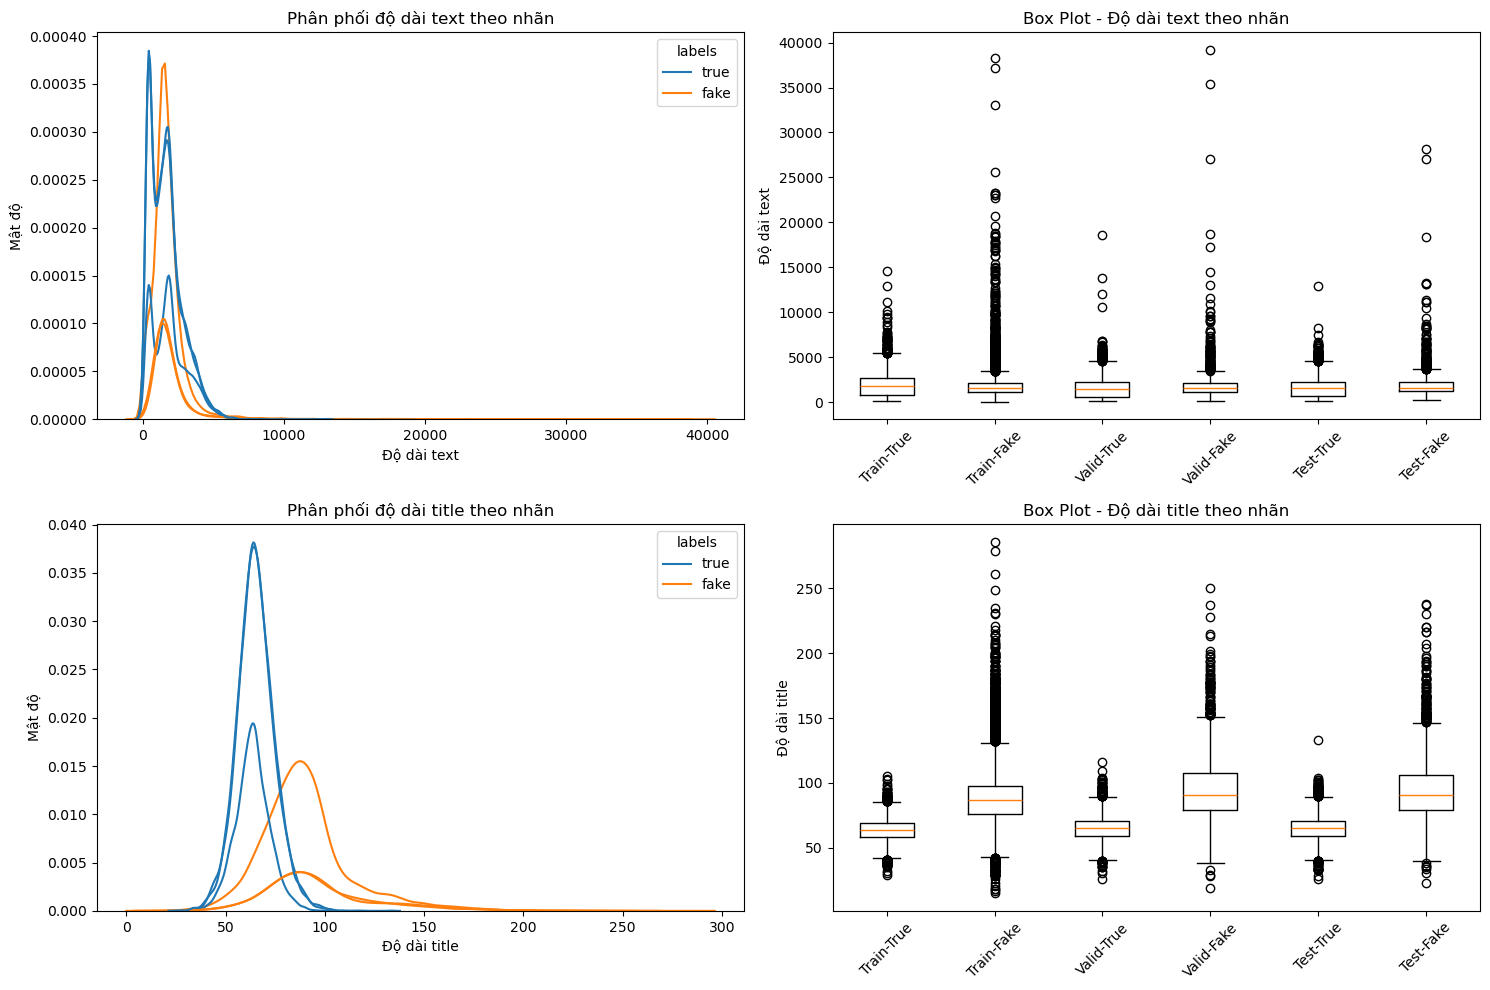

In [59]:
# Phân tích độ dài văn bản
# Tính độ dài cho text và title
for df in [df_train, df_valid, df_test]:
    df['text_length'] = df['text'].str.len()
    df['title_length'] = df['title'].str.len()

print("\nPhân tích thống kê về độ dài văn bản:")
plt.figure(figsize=(15, 10))

# Phân phối độ dài text
plt.subplot(2, 2, 1)
for name, df in zip(['Train', 'Valid', 'Test'], [df_train, df_valid, df_test]):
    sns.kdeplot(data=df, x='text_length', hue='labels', label=name)
plt.title('Phân phối độ dài text theo nhãn')
plt.xlabel('Độ dài text')
plt.ylabel('Mật độ')

# Box plot độ dài text
plt.subplot(2, 2, 2)
data = []
labels = []
for name, df in zip(['Train', 'Valid', 'Test'], [df_train, df_valid, df_test]):
    data.extend([df[df['labels']=='true']['text_length'], df[df['labels']=='fake']['text_length']])
    labels.extend([f'{name}-True', f'{name}-Fake'])
plt.boxplot(data, labels=labels)
plt.title('Box Plot - Độ dài text theo nhãn')
plt.xticks(rotation=45)
plt.ylabel('Độ dài text')

# Phân phối độ dài title
plt.subplot(2, 2, 3)
for name, df in zip(['Train', 'Valid', 'Test'], [df_train, df_valid, df_test]):
    sns.kdeplot(data=df, x='title_length', hue='labels', label=name)
plt.title('Phân phối độ dài title theo nhãn')
plt.xlabel('Độ dài title')
plt.ylabel('Mật độ')

# Box plot độ dài title
plt.subplot(2, 2, 4)
data = []
labels = []
for name, df in zip(['Train', 'Valid', 'Test'], [df_train, df_valid, df_test]):
    data.extend([df[df['labels']=='true']['title_length'], df[df['labels']=='fake']['title_length']])
    labels.extend([f'{name}-True', f'{name}-Fake'])
plt.boxplot(data, labels=labels)
plt.title('Box Plot - Độ dài title theo nhãn')
plt.xticks(rotation=45)
plt.ylabel('Độ dài title')

plt.tight_layout()
plt.show()

In [60]:
# Chuẩn bị dữ liệu và vectorization
# Tạo features và labels
X_train = df_train['text']
# Chuyển đổi nhãn từ 'true'/'fake' sang 1/0
y_train = (df_train['labels'] == 'true').astype(int)
X_valid = df_valid['text']
y_valid = (df_valid['labels'] == 'true').astype(int)
X_test = df_test['text']
y_test = (df_test['labels'] == 'true').astype(int)

print("Kiểm tra giá trị nhãn sau khi chuyển đổi:")
print("\nTrain set:", np.unique(y_train))
print("Valid set:", np.unique(y_valid))
print("Test set:", np.unique(y_test))

# Vectorization với TF-IDF
print("\nVectorizing dữ liệu...")
vectorizer = TfidfVectorizer(max_features=5000)
xv_train = vectorizer.fit_transform(X_train)
xv_valid = vectorizer.transform(X_valid)
xv_test = vectorizer.transform(X_test)

# Thêm features độ dài
train_lengths = scipy.sparse.csr_matrix(np.column_stack([
    df_train['text_length'].values,
    df_train['title_length'].values
]))
valid_lengths = scipy.sparse.csr_matrix(np.column_stack([
    df_valid['text_length'].values,
    df_valid['title_length'].values
]))
test_lengths = scipy.sparse.csr_matrix(np.column_stack([
    df_test['text_length'].values,
    df_test['title_length'].values
]))

# Kết hợp features
xv_train_combined = scipy.sparse.hstack([xv_train, train_lengths])
xv_valid_combined = scipy.sparse.hstack([xv_valid, valid_lengths])
xv_test_combined = scipy.sparse.hstack([xv_test, test_lengths])

Kiểm tra giá trị nhãn sau khi chuyển đổi:

Train set: [0 1]
Valid set: [0 1]
Test set: [0 1]

Vectorizing dữ liệu...


In [61]:
# SMOTE để cân bằng dữ liệu
print("Áp dụng SMOTE cho training data...")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(xv_train_combined, y_train)

print("\nPhân bố dữ liệu trước SMOTE:")
print(Counter(y_train))
print("\nPhân bố dữ liệu sau SMOTE:")
print(Counter(y_train_resampled))

Áp dụng SMOTE cho training data...

Phân bố dữ liệu trước SMOTE:
Counter({0: 13781, 1: 7746})

Phân bố dữ liệu sau SMOTE:
Counter({1: 13781, 0: 13781})

Phân bố dữ liệu trước SMOTE:
Counter({0: 13781, 1: 7746})

Phân bố dữ liệu sau SMOTE:
Counter({1: 13781, 0: 13781})


In [62]:
# Hàm đánh giá model
def evaluate_model(model, X_train, y_train, X_valid, y_valid, X_test, y_test, model_name):
    # Training
    print(f"\nTraining {model_name}...")
    model.fit(X_train, y_train)
    
    # Đánh giá trên validation set
    y_valid_pred = model.predict(X_valid)
    valid_acc = accuracy_score(y_valid, y_valid_pred)
    print(f"\nKết quả {model_name} trên validation set:")
    print(f"Accuracy: {valid_acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_valid, y_valid_pred))
    
    # Đánh giá trên test set
    y_test_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    print(f"\nKết quả {model_name} trên test set:")
    print(f"Accuracy: {test_acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred))
    
    # Vẽ confusion matrix
    plt.figure(figsize=(12, 5))
    
    # Confusion matrix cho validation set
    plt.subplot(1, 2, 1)
    cm_valid = confusion_matrix(y_valid, y_valid_pred)
    sns.heatmap(cm_valid, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}\nValidation Set')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # Confusion matrix cho test set
    plt.subplot(1, 2, 2)
    cm_test = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}\nTest Set')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()
    
    return valid_acc, test_acc, y_valid_pred, y_test_pred

Training Logistic Regression model...

Training Logistic Regression...

Kết quả Logistic Regression trên validation set:
Accuracy: 0.9417

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.96      0.87      1655
           1       0.99      0.94      0.96      6722

    accuracy                           0.94      8377
   macro avg       0.89      0.95      0.92      8377
weighted avg       0.95      0.94      0.94      8377


Kết quả Logistic Regression trên test set:
Accuracy: 0.9375

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.96      0.86      1655
           1       0.99      0.93      0.96      6723

    accuracy                           0.94      8378
   macro avg       0.88      0.95      0.91      8378
weighted avg       0.95      0.94      0.94      8378


Kết quả Logistic Regression trên validation set:
Accuracy: 0.9417

Classification Report:
        

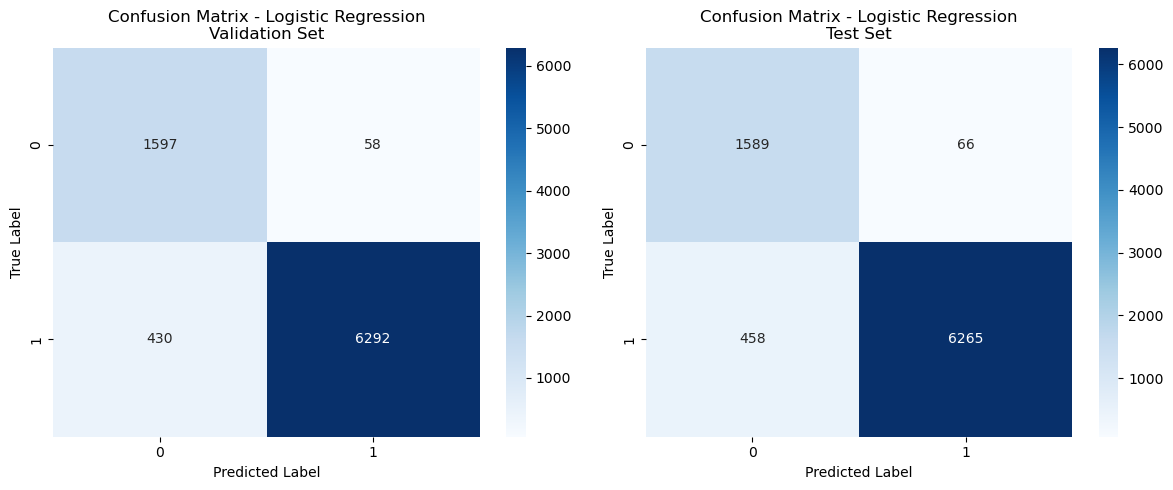

In [63]:
# Logistic Regression
print("Training Logistic Regression model...")
lr_model = LogisticRegression(random_state=42)
lr_results = evaluate_model(
    lr_model,
    X_train_resampled, y_train_resampled,
    xv_valid_combined, y_valid,
    xv_test_combined, y_test,
    "Logistic Regression"
)

Training Decision Tree model...

Training Decision Tree...

Kết quả Decision Tree trên validation set:
Accuracy: 0.8928

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.96      0.78      1655
           1       0.99      0.88      0.93      6722

    accuracy                           0.89      8377
   macro avg       0.82      0.92      0.85      8377
weighted avg       0.92      0.89      0.90      8377


Kết quả Decision Tree trên test set:
Accuracy: 0.8854

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.94      0.76      1655
           1       0.98      0.87      0.92      6723

    accuracy                           0.89      8378
   macro avg       0.81      0.91      0.84      8378
weighted avg       0.92      0.89      0.89      8378


Kết quả Decision Tree trên validation set:
Accuracy: 0.8928

Classification Report:
              precision    recall  f1-

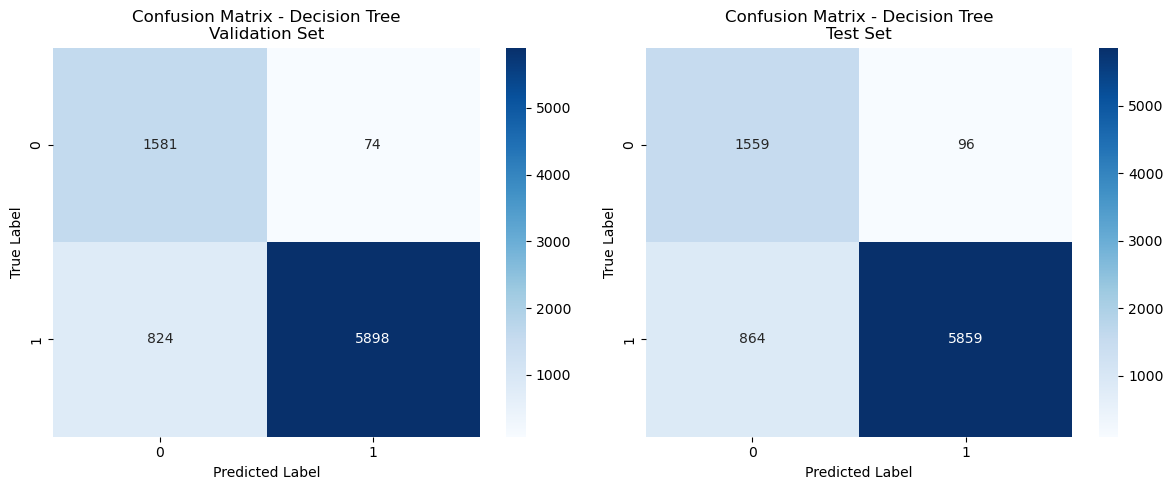

In [64]:
# Decision Tree
print("Training Decision Tree model...")
dt_model = DecisionTreeClassifier(random_state=42)
dt_results = evaluate_model(
    dt_model,
    X_train_resampled, y_train_resampled,
    xv_valid_combined, y_valid,
    xv_test_combined, y_test,
    "Decision Tree"
)

Training Random Forest model...

Training Random Forest...

Kết quả Random Forest trên validation set:
Accuracy: 0.8920

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.99      0.78      1655
           1       1.00      0.87      0.93      6722

    accuracy                           0.89      8377
   macro avg       0.82      0.93      0.86      8377
weighted avg       0.93      0.89      0.90      8377


Kết quả Random Forest trên validation set:
Accuracy: 0.8920

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.99      0.78      1655
           1       1.00      0.87      0.93      6722

    accuracy                           0.89      8377
   macro avg       0.82      0.93      0.86      8377
weighted avg       0.93      0.89      0.90      8377


Kết quả Random Forest trên test set:
Accuracy: 0.8867

Classification Report:
              precision    recall  f1-

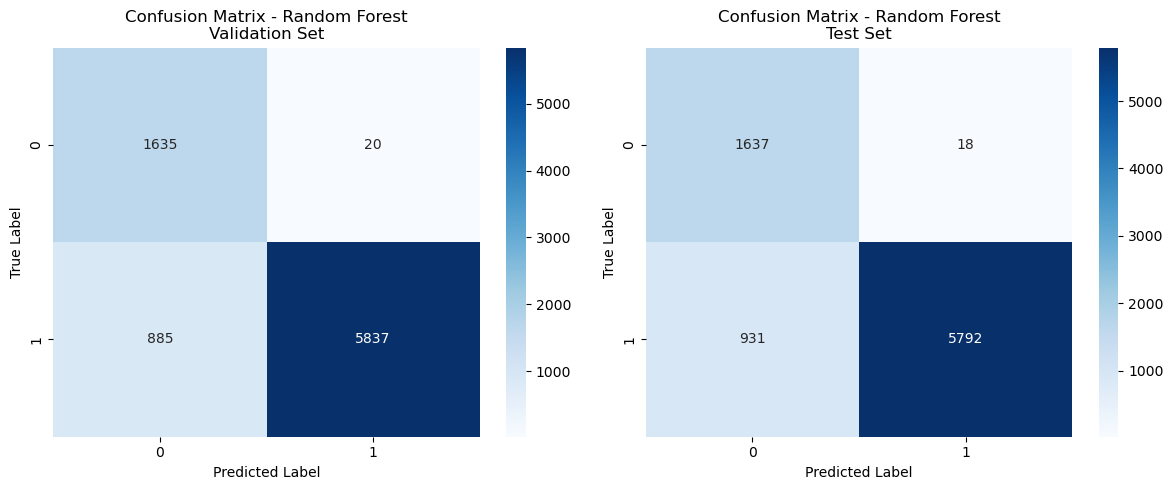

In [65]:
# Random Forest
print("Training Random Forest model...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_results = evaluate_model(
    rf_model,
    X_train_resampled, y_train_resampled,
    xv_valid_combined, y_valid,
    xv_test_combined, y_test,
    "Random Forest"
)

Training Linear SVC model...

Training Linear SVC...

Kết quả Linear SVC trên validation set:
Accuracy: 0.9728

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.93      1655
           1       1.00      0.97      0.98      6722

    accuracy                           0.97      8377
   macro avg       0.94      0.98      0.96      8377
weighted avg       0.98      0.97      0.97      8377


Kết quả Linear SVC trên test set:
Accuracy: 0.9703

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93      1655
           1       1.00      0.97      0.98      6723

    accuracy                           0.97      8378
   macro avg       0.94      0.98      0.96      8378
weighted avg       0.97      0.97      0.97      8378


Kết quả Linear SVC trên validation set:
Accuracy: 0.9728

Classification Report:
              precision    recall  f1-score   support

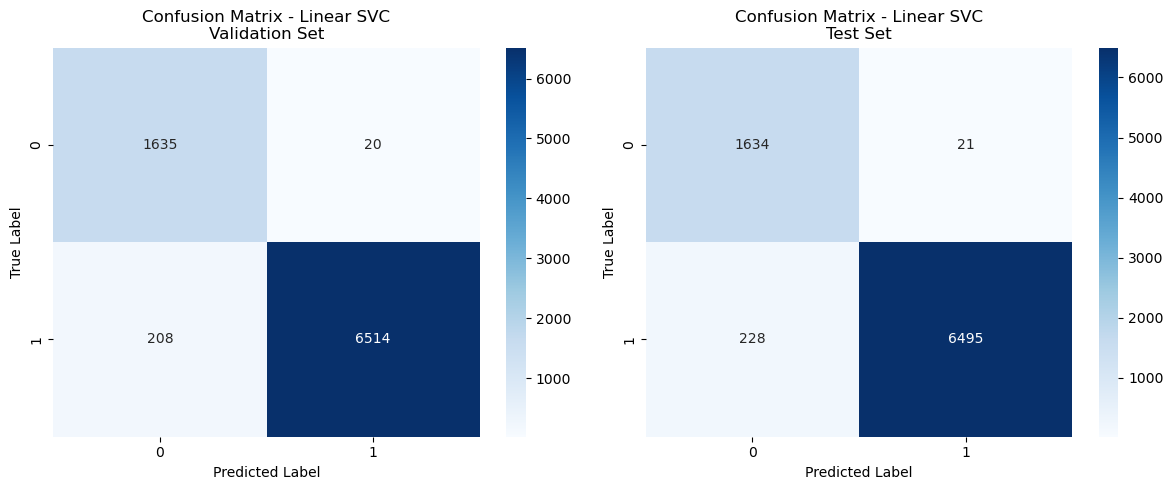

In [66]:
# Linear SVC
print("Training Linear SVC model...")
svc_model = LinearSVC(random_state=42)
svc_results = evaluate_model(
    svc_model,
    X_train_resampled, y_train_resampled,
    xv_valid_combined, y_valid,
    xv_test_combined, y_test,
    "Linear SVC"
)

Training XGBoost model...

Training XGBoost...

Kết quả XGBoost trên validation set:
Accuracy: 0.9408

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.99      0.87      1655
           1       1.00      0.93      0.96      6722

    accuracy                           0.94      8377
   macro avg       0.89      0.96      0.92      8377
weighted avg       0.95      0.94      0.94      8377


Kết quả XGBoost trên test set:
Accuracy: 0.9338

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.99      0.85      1655
           1       1.00      0.92      0.96      6723

    accuracy                           0.93      8378
   macro avg       0.88      0.95      0.91      8378
weighted avg       0.95      0.93      0.94      8378


Kết quả XGBoost trên validation set:
Accuracy: 0.9408

Classification Report:
              precision    recall  f1-score   support

           0 

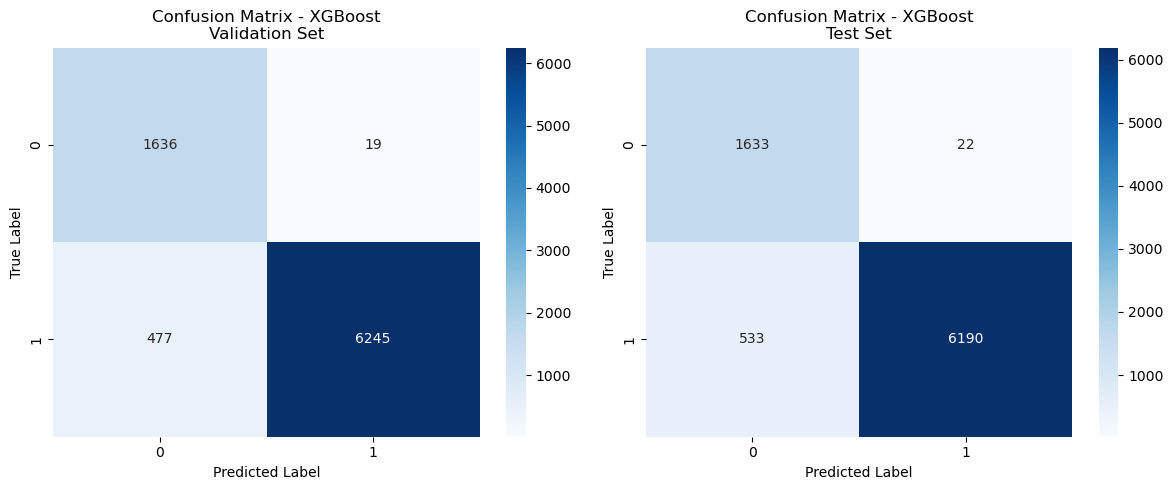

In [67]:
# XGBoost
print("Training XGBoost model...")
xgb_model = XGBClassifier(random_state=42)
xgb_results = evaluate_model(
    xgb_model,
    X_train_resampled, y_train_resampled,
    xv_valid_combined, y_valid,
    xv_test_combined, y_test,
    "XGBoost"
)

Training Naive Bayes model...

Training Naive Bayes...

Kết quả Naive Bayes trên validation set:
Accuracy: 0.5798

Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.81      0.43      1655
           1       0.92      0.52      0.67      6722

    accuracy                           0.58      8377
   macro avg       0.61      0.67      0.55      8377
weighted avg       0.80      0.58      0.62      8377


Kết quả Naive Bayes trên test set:
Accuracy: 0.5784

Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.79      0.43      1655
           1       0.91      0.53      0.67      6723

    accuracy                           0.58      8378
   macro avg       0.60      0.66      0.55      8378
weighted avg       0.79      0.58      0.62      8378



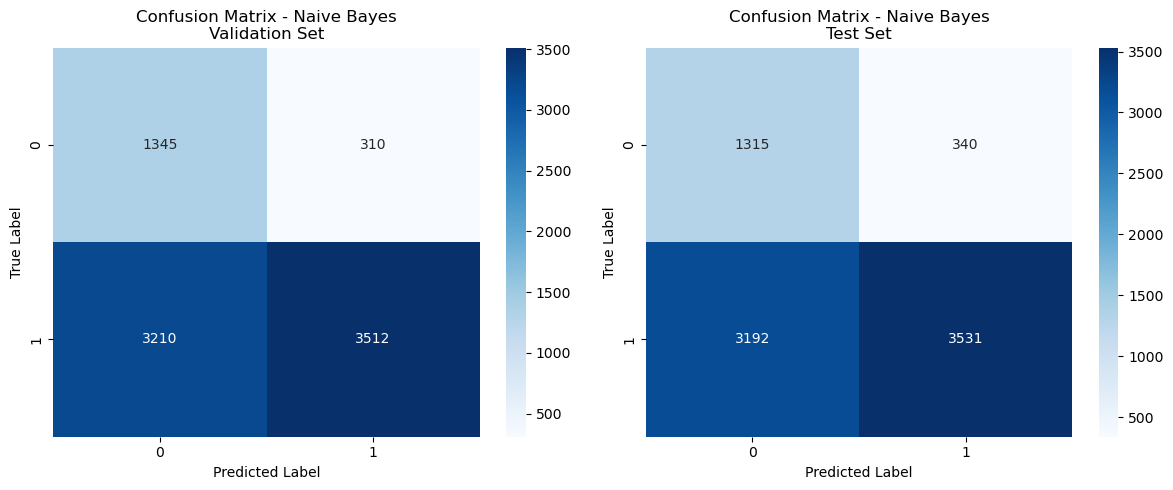

In [68]:
# Naive Bayes
print("Training Naive Bayes model...")
nb_model = MultinomialNB()
nb_results = evaluate_model(
    nb_model,
    X_train_resampled, y_train_resampled,
    xv_valid_combined, y_valid,
    xv_test_combined, y_test,
    "Naive Bayes"
)


Bảng so sánh kết quả các model:
              Model  Validation Accuracy  Test Accuracy
Logistic Regression             0.941745       0.937455
      Decision Tree             0.892802       0.885414
      Random Forest             0.891966       0.886727
         Linear SVC             0.972783       0.970279
            XGBoost             0.940790       0.933755
        Naive Bayes             0.579802       0.578420


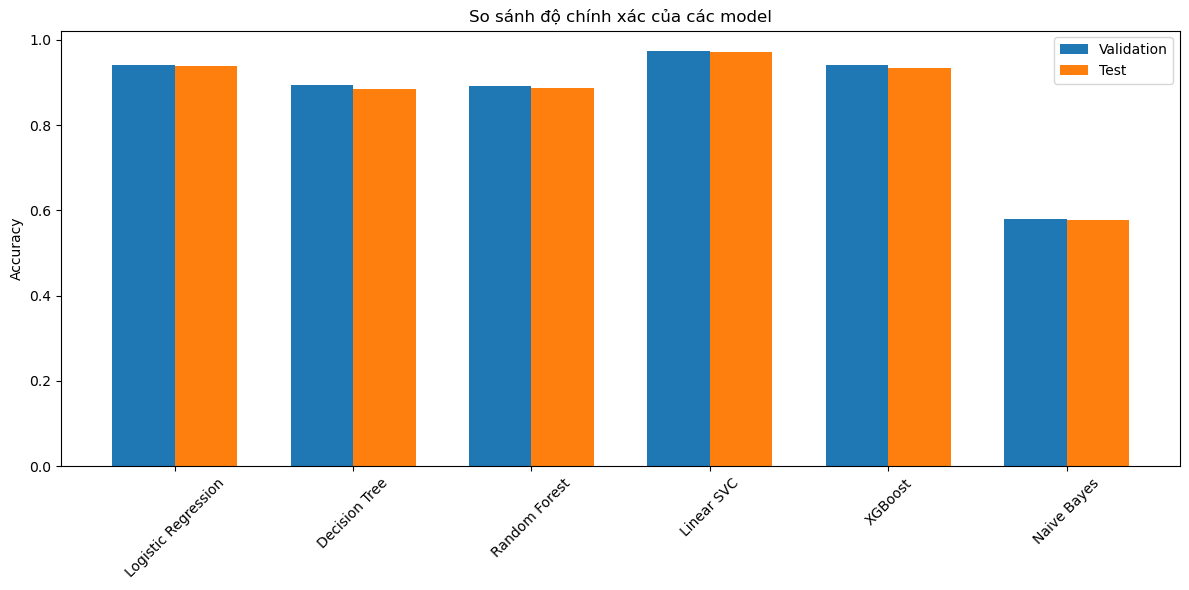


Model có hiệu suất tốt nhất trên tập test: Linear SVC
Validation accuracy: 0.9728
Test accuracy: 0.9703


In [69]:
# So sánh kết quả các model
models_results = {
    'Logistic Regression': lr_results,
    'Decision Tree': dt_results,
    'Random Forest': rf_results,
    'Linear SVC': svc_results,
    'XGBoost': xgb_results,
    'Naive Bayes': nb_results
}

# Tạo DataFrame để so sánh
results_df = pd.DataFrame({
    'Model': list(models_results.keys()),
    'Validation Accuracy': [res[0] for res in models_results.values()],
    'Test Accuracy': [res[1] for res in models_results.values()]
})

print("\nBảng so sánh kết quả các model:")
print(results_df.to_string(index=False))

# Vẽ biểu đồ so sánh
plt.figure(figsize=(12, 6))
x = np.arange(len(results_df['Model']))
width = 0.35

plt.bar(x - width/2, results_df['Validation Accuracy'], width, label='Validation')
plt.bar(x + width/2, results_df['Test Accuracy'], width, label='Test')
plt.ylabel('Accuracy')
plt.title('So sánh độ chính xác của các model')
plt.xticks(x, results_df['Model'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Tìm model tốt nhất
best_model = results_df.loc[results_df['Test Accuracy'].idxmax()]
print(f"\nModel có hiệu suất tốt nhất trên tập test: {best_model['Model']}")
print(f"Validation accuracy: {best_model['Validation Accuracy']:.4f}")
print(f"Test accuracy: {best_model['Test Accuracy']:.4f}")